### Importing Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line

import torchvision.transforms.v2 as v2
import wandb

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [ ]:
!unzip data.zip

### Defining the Dataset Class

In [39]:
class Cell_data(Dataset):
    def __init__(self, data_dir, size, train=True, train_test_split=0.8, augment_data=True):
        ##########################inputs##################################
        # data_dir(string) - directory of the data#########################
        # size(int) - size of the images you want to use###################
        # train(boolean) - train data or test data#########################
        # train_test_split(float) - the portion of the data for training###
        # augment_data(boolean) - use data augmentation or not#############
        super(Cell_data, self).__init__()
        # initialize the data class
        self.data_dir = data_dir
        self.size = size
        self.train = train
        self.train_test_split = train_test_split
        self.augment_data = augment_data

        # read images and masks
        image_path = os.path.join(data_dir, 'scans')
        mask_path = os.path.join(data_dir, 'labels')

        image_files = sorted(
            [os.path.join(image_path, file) for file in os.listdir(image_path) if file.endswith('.bmp')])
        masks = sorted([os.path.join(mask_path, file) for file in os.listdir(mask_path) if file.endswith('.bmp')])

        # split train set & test set
        idx = int(train_test_split * len(image_files))
        if train:
            self.images = image_files[:idx]
            self.masks = masks[:idx]
        else:
            self.images = image_files[idx:]
            self.masks = masks[idx:]

    def __getitem__(self, idx):

        # load image and mask from index idx of your data
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        image_PIL = Image.open(image_path).resize((self.size, self.size))
        mask_PIL = Image.open(mask_path).resize((self.size, self.size))

        if not self.train:
            return self.load_image(image_PIL), self.load_mask(mask_PIL)

        # data augmentation part
        # reference: https://pytorch.org/vision/main/auto_examples/transforms
        # /plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

        if self.augment_data:
            augment_mode = np.random.randint(0, 6)
            if augment_mode == 0:
                # flip image vertically
                image_PIL = TF.vflip(image_PIL)
                mask_PIL = TF.vflip(mask_PIL)

            elif augment_mode == 1:
                # flip image horizontally
                image_PIL = TF.hflip(image_PIL)
                mask_PIL = TF.hflip(mask_PIL)

            elif augment_mode == 2:
                # zoom image
                output_size = (self.size, self.size)
                resize_transform = v2.RandomResizedCrop(size=output_size)
                params = resize_transform.get_params(image_PIL, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.))

                image_PIL = TF.resized_crop(image_PIL, *params, size=output_size)
                mask_PIL = TF.resized_crop(mask_PIL, *params, size=output_size)

            elif augment_mode == 3:
                # rotate image
                angle = random.uniform(0, 360)
                image_PIL = TF.rotate(image_PIL, angle)
                mask_PIL = TF.rotate(mask_PIL, angle)

            elif augment_mode == 4:
                # Apply ElasticTransform
                # Based on the original paper, alpha = 10, sigma = 10
                elastic_transform = v2.ElasticTransform(alpha=10.0, sigma=10.0)
                image_PIL = elastic_transform(image_PIL)
                mask_PIL = elastic_transform(mask_PIL)

            else:
                # Gamma correction
                # reference: https://pytorch.org/vision/main/generated/torchvision.transforms.functional.adjust_gamma.html
                gamma = random.uniform(0.5, 1.5)
                image_PIL = v2.functional.adjust_gamma(image_PIL, gamma=gamma)

        # return image and mask in tensors
        image_tensor = self.load_image(image_PIL)
        mask = self.load_mask(mask_PIL)
        return image_tensor, mask

    # Helper function to load images, given file, return a tensor
    def load_image(self, file):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        image_tensor = transform(file)
        return image_tensor

    # Helper function to load masks, given file, return a tensor
    def load_mask(self, file):
        mask_tensor = torch.from_numpy(np.array(file)).long()  # convert to tensor
        return mask_tensor

    def __len__(self):
        # print(f"Train: {self.train}, length: {len(self.images)}")
        return len(self.images)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [50]:
class twoConvBlock(nn.Module):
    """Part 1  The Convolutional blocks"""

    # initialize the block
    def __init__(self, input_channel, output_channel):
        super(twoConvBlock, self).__init__()
        self.doubleConvBlock = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),  # 3 × 3 un-padded convolution layer
            nn.ReLU(inplace=True),  # ReLU
            nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),  # 3 × 3 un-padded convolution layer
            nn.BatchNorm2d(output_channel),  # Batch normalization layer
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # implement the forward path
        return self.doubleConvBlock(x)


class downStep(nn.Module):
    """Part 2  The Contracting path"""

    # initialize the down path
    def __init__(self, input_channel, output_channel):
        super(downStep, self).__init__()
        self.convBlock = twoConvBlock(input_channel, output_channel)  # 2 conv blocks
        self.maxPool = nn.MaxPool2d(kernel_size=2)  # 2 x 2 max pool

    def forward(self, x):
        # implement the forward path
        x = self.convBlock(x)
        x_maxPool = self.maxPool(x)
        return x, x_maxPool


class upStep(nn.Module):
    """Part 3  The Expansive path"""

    def __init__(self, input_channel, output_channel):
        super(upStep, self).__init__()
        # initialize the up path
        self.upConv = nn.ConvTranspose2d(input_channel, output_channel, kernel_size=2, stride=2)  # transpose convolutions
        self.convBlock = twoConvBlock(output_channel * 2, output_channel)  #

    def forward(self, x, skip_connection):
        # implement the forward path
        x = self.upConv(x)

        # process crop and copy
        # reference : https://github.com/milesial/Pytorch-UNet/blob/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db/unet/unet_parts.py
        # target_size = (x.size(2), x.size(3))
        # skip_connection = v1.center_crop(skip_connection, output_size=target_size)
        diffY = skip_connection.size()[2] - x.size()[2]
        diffX = skip_connection.size()[3] - x.size()[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip_connection, x], dim=1)
        new_x = self.convBlock(x)
        return new_x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        # initialize the complete model
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting
        self.inc = downStep(n_channels, 64)
        self.down1 = downStep(64, 128)
        self.down2 = downStep(128, 256)
        self.down3 = downStep(256, 512)

        # Bottom, no max pooling
        self.bot = twoConvBlock(512, 1024)

        # Expansive
        self.up1 = upStep(1024, 512)
        self.up2 = upStep(512, 256)
        self.up3 = upStep(256, 128)
        self.up4 = upStep(128, 64)

        # Output
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # implement the forward path
        x1, x1_maxpool = self.inc(x)
        x2, x2_maxpool = self.down1(x1_maxpool)
        x3, x3_maxpool = self.down2(x2_maxpool)
        x4, x4_maxpool = self.down3(x3_maxpool)

        x_bot = self.bot(x4_maxpool)

        x = self.up1(x_bot, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        x_out = self.outc(x)

        return F.sigmoid(x_out)


In [51]:
print(torch.cuda.is_available())  # Should return True if CUDA is installed correctly
print(torch.cuda.device_count())  # Number of GPUs available

True
1


### Model S&L

In [52]:
dirs = os.getcwd()
# Function to save a checkpoint in the TensorBoard log directory
def save_checkpoint(model, optimizer, epoch, loss_metric, accuracy_metric, checkpoint_dir=dirs):
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"

    # Use .compute() to get the values of the metrics
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss_metric,  # Get the computed loss
        'accuracy': accuracy_metric  # Get the computed accuracy
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

# Function to load a checkpoint from the TensorBoard log directory
def load_checkpoint(model, optimizer, checkpoint_dir=dirs):
    import glob
    # Find the latest checkpoint (e.g., based on the highest epoch number)
    checkpoint_paths = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pth")
    checkpoint_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint = checkpoint_paths[-1]

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Checkpoint loaded from {latest_checkpoint}. Resuming training from epoch {start_epoch}')

    return start_epoch, loss, accuracy  # You can return these for reference but don't update accuracy_metric with them

### Training

In [54]:
#Paramteres

#learning rate
lr = 1e-4

#number of training epochs
epoch_n = 20

#input image-mask size
# image_size = 572
image_size = 256
# image_size = 128

#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')

# wandb setup
# Initialize wandb project, reference: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb#scrollTo=R_3hYQyqb0fJ
wandb.init(project="assignment2_unet_training", config={
    "learning_rate": lr,
    "epochs": epoch_n,
    "batch_size": batch_size,
    "image_size": image_size
})

trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet(n_channels=1, n_classes=2).to('cuda:0').to(device)

criterion = nn.CrossEntropyLoss()
# Use AdamW for better weight decay
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.8, 0.9), weight_decay=5e-4)

if load:
  print('loading model')
  load_checkpoint(model,optimizer,dirs)
  # model.load_state_dict(torch.load('checkpoint_1e-08_10.pt'))


model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    
    image = image.to(device)
    label = label.squeeze(1).long().to(device)

    pred = model(image)

    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]
    loss = criterion(pred, label)

    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    if i % 5 == 0:
        print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
        wandb.log({'batch_loss': loss.item() / batch_size})
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  wandb.log({'epoch_loss': epoch_loss / trainset.__len__()})
  
  
  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      image = image.to(device)
      label = label.squeeze(1).long().to(device)

      pred = model(image)
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()
    
    accuracy = correct / total
    test_loss = total_loss / testset.__len__()
    print('Accuracy: %.4f ---- Loss: %.4f' % (accuracy, test_loss))
    wandb.log({'test_loss': test_loss, 'accuracy': accuracy})
    if e % 5 == 0 or e == epoch_n - 1:
        save_checkpoint(model,optimizer,e,epoch_loss / trainset.__len__(),correct / total)
wandb.finish()

batch 0 --- Loss: 0.1810
batch 5 --- Loss: 0.1777
Epoch 1 / 20 --- Loss: 0.1894
Accuracy: 0.2584 ---- Loss: 0.1741
Checkpoint saved at I:\TrainingField\Unet\materials/checkpoint_epoch_1.pth
batch 0 --- Loss: 0.1606
batch 5 --- Loss: 0.1748
Epoch 2 / 20 --- Loss: 0.1784
Accuracy: 0.2584 ---- Loss: 0.1741
batch 0 --- Loss: 0.1757
batch 5 --- Loss: 0.1504
Epoch 3 / 20 --- Loss: 0.1675
Accuracy: 0.7979 ---- Loss: 0.1703
batch 0 --- Loss: 0.1497
batch 5 --- Loss: 0.1489
Epoch 4 / 20 --- Loss: 0.1609
Accuracy: 0.7351 ---- Loss: 0.1651
batch 0 --- Loss: 0.1553
batch 5 --- Loss: 0.1438
Epoch 5 / 20 --- Loss: 0.1574
Accuracy: 0.7412 ---- Loss: 0.1576
batch 0 --- Loss: 0.1403
batch 5 --- Loss: 0.1485
Epoch 6 / 20 --- Loss: 0.1573
Accuracy: 0.7631 ---- Loss: 0.1548
Checkpoint saved at I:\TrainingField\Unet\materials/checkpoint_epoch_6.pth
batch 0 --- Loss: 0.1410
batch 5 --- Loss: 0.1381
Epoch 7 / 20 --- Loss: 0.1527
Accuracy: 0.8458 ---- Loss: 0.1388
batch 0 --- Loss: 0.1390
batch 5 --- Loss: 0.

accuracy,▁▁▇▆▆▇████▇████▆██▇█
batch_loss,██▆▇▇▄▄▄▅▄▃▄▃▃▃▃▄▄▃▃▃▃▃▂▄▂▃▃▂▄▂▂▂▃▂▂▂▁▂▃
epoch_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁
test_loss,██▇▇▅▅▂▂▁▂▃▂▁▁▂▅▂▂▂▁
accuracy,0.88085
batch_loss,0.14077
epoch_loss,0.14207
test_loss,0.1294


### Testing and Visualization

In [55]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(len(testset)):
    image, labels = testset.__getitem__(i)
    
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)
    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()
    
    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    
    output_masks.append(output_mask)
    output_labels.append(labels)
    

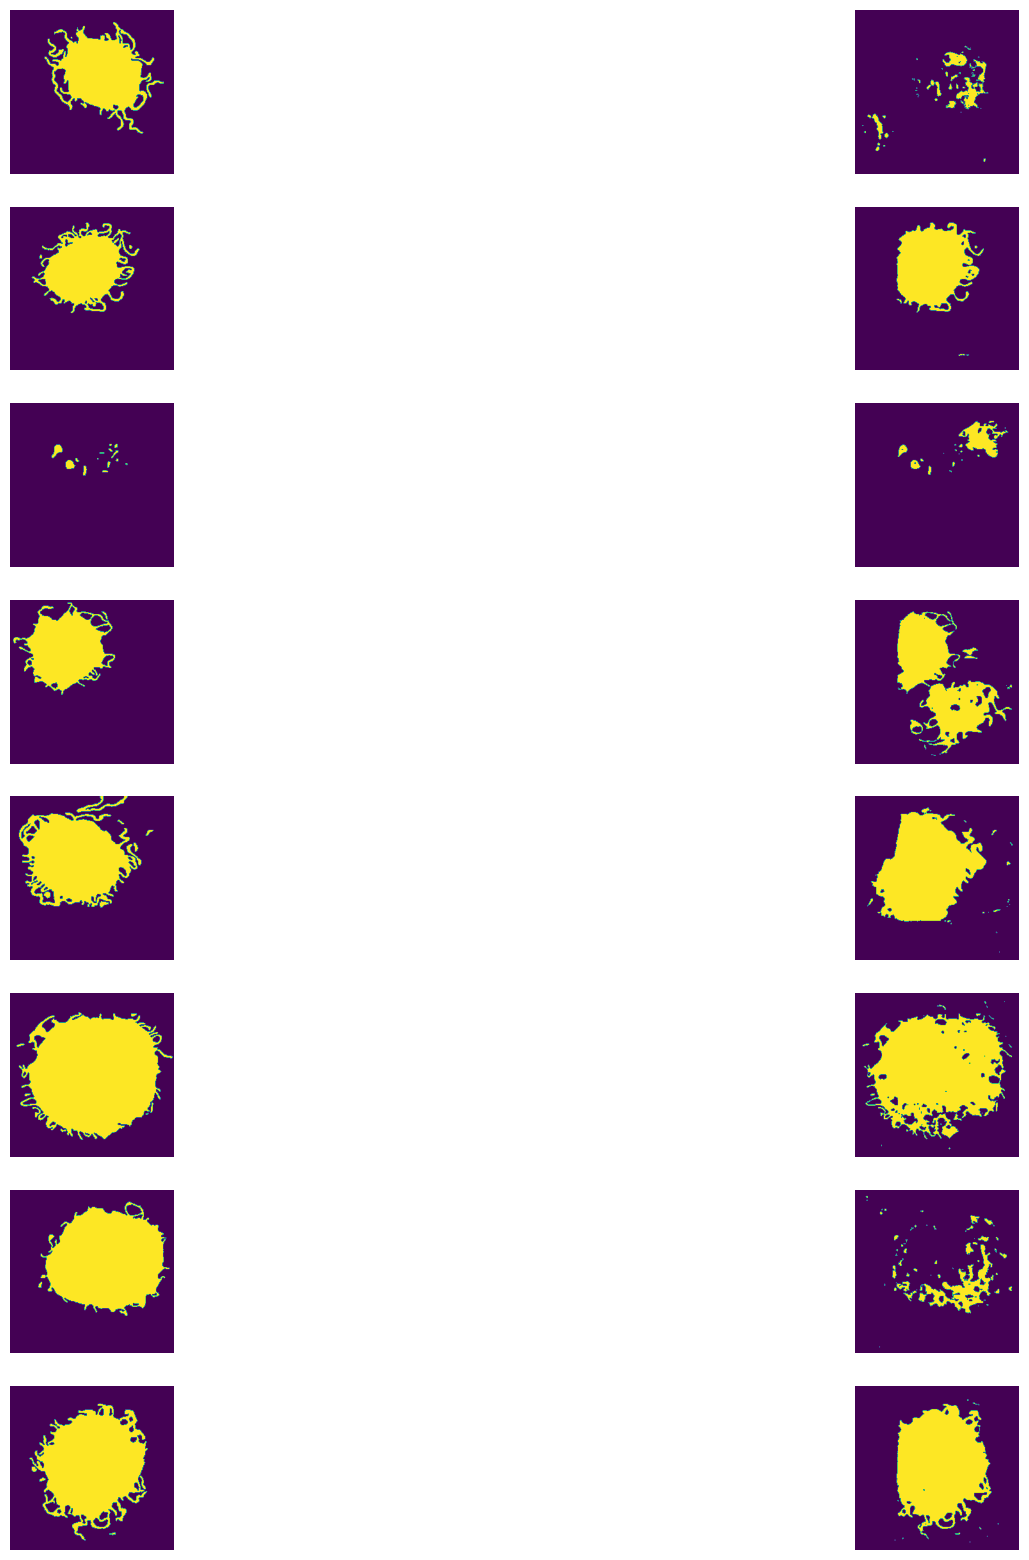

In [56]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i].squeeze())
  axes[i, 1].axis('off')